In [1]:
#If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

#In addition, uncomment and run the following code:
# !pip install pzflow

#Intro to pzflow

#This notebook demonstrates building a normalizing flow with pzflow to learn the joint probability distribution of some 2-D data.#

#You do not need to have any previous knowledge of normalizing flows to get started with pzflow, however if you are interested, here are some good sources:

#    Eric Jang's tutorial: part 1, part 2
#    Here is a comprehensive list of papers, blogs, videos, and packages
#    Two good intro papers using Coupling Layers: NICE, Real NVP
#    The paper on Neural Spline Couplings

import jax.numpy as np
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd
import GCRCatalogs
import timeit
import numpy as onp

In [2]:
cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image_with_photozs_v1")

In [3]:
quantities = ['galaxy_id', 'redshift', 'ra', 'dec','mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 
     'size_true', 'size_minor_true', 'morphology/totalSersicIndex', 
     'morphology/totalEllipticity', 'baseDC2/sfr', 'stellar_mass', 'totalStarFormationRate', 'position_angle_true', 'mag_err_u_photoz', 'mag_err_g_photoz', 'mag_err_r_photoz', 'mag_err_i_photoz', 'mag_err_z_photoz', 'mag_err_y_photoz']
filters=['redshift<1', 'Mag_true_r_sdss_z0<-15.']

In [4]:
start_time = timeit.default_timer()
logsfrtot = []
redshift  = []
sersic    = []
size      = []
logmass   = []
g = []
r = []
i = []
z = []
galid = []
ra = []
dec = []
ellip = []

c = 0
for gal in cosmo.get_quantities(quantities, filters, return_iterator=True):
    logsfrtot.append(np.log10(gal['totalStarFormationRate']))
    redshift.append(gal['redshift'])
    sersic.append(gal['morphology/totalSersicIndex'])
    size.append(gal['size_true'])
    logmass.append(np.log10(gal['stellar_mass']))
    g.append(gal['Mag_true_g_sdss_z0'])
    r.append(gal['Mag_true_r_sdss_z0'])
    i.append(gal['Mag_true_i_sdss_z0'])
    z.append(gal['Mag_true_z_sdss_z0'])
    galid.append(gal['galaxy_id'])
    ra.append(gal['ra'])
    dec.append(gal['dec'])
    ellip.append(gal['morphology/totalEllipticity'])
    elapsed = timeit.default_timer() - start_time
    print(c, "Elapsed time = ", elapsed)
    if c==50:
        break
    c+=1

0 Elapsed time =  60.083124144002795
1 Elapsed time =  63.523105891013984
2 Elapsed time =  66.13484961001086
3 Elapsed time =  68.96249388201977
4 Elapsed time =  73.12788466300117
5 Elapsed time =  75.88384982701973
6 Elapsed time =  78.77500604500528
7 Elapsed time =  81.75494759800495
8 Elapsed time =  85.34125889302231
9 Elapsed time =  88.23450880101882
10 Elapsed time =  90.99883978601429
11 Elapsed time =  94.942247605999
12 Elapsed time =  97.5876667080156
13 Elapsed time =  100.33090649801306
14 Elapsed time =  103.9758385810128
15 Elapsed time =  106.80463000401505
16 Elapsed time =  109.43152422600542
17 Elapsed time =  405.5600883520092
18 Elapsed time =  415.8416911860113
19 Elapsed time =  419.77896309201606
20 Elapsed time =  423.35089200301445
21 Elapsed time =  427.0746110760083
22 Elapsed time =  430.75310112701845
23 Elapsed time =  433.8827324010199
24 Elapsed time =  437.1447497869958
25 Elapsed time =  440.8869011790084
26 Elapsed time =  443.53936094700475
27 El

In [5]:
data_unscaled = {}
data_unscaled['logSFRtot'] = onp.concatenate(logsfrtot)
data_unscaled['redshift']  = onp.concatenate(redshift)
data_unscaled['morphology/totalSersicIndex'] = onp.concatenate(sersic)
data_unscaled['size_true'] = onp.concatenate(size)
data_unscaled['logmass'] = onp.concatenate(logmass)
data_unscaled['Mag_true_g_sdss_z0']  = onp.concatenate(g)
data_unscaled['Mag_true_r_sdss_z0']  = onp.concatenate(r)
data_unscaled['Mag_true_i_sdss_z0']  = onp.concatenate(i)
data_unscaled['Mag_true_z_sdss_z0']  = onp.concatenate(z)
data_unscaled['galaxy_id'] = onp.concatenate(galid)
data_unscaled['ra'] = onp.concatenate(ra)
data_unscaled['dec'] = onp.concatenate(dec)
data_unscaled['morphology/totalEllipticity'] = onp.concatenate(ellip)

In [6]:
data_unscaled = pd.DataFrame(data_unscaled)

In [7]:
def f(logmass):
    return 2*logmass - 24

#get rid of that weird clump M* > 10^10 Msol and logSFR = -5
data_unscaled = data_unscaled[onp.asarray((data_unscaled['logSFRtot'] - 9) > f(data_unscaled['logmass']))]
# x = np.linspace(6,12)
# plt.figure(figsize=(10,7))
# plt.plot(data_unscaled['logmass'].values[::30],data_unscaled['logSFRtot'].values[::30]-9,'o', ms=0.1, alpha=0.6)
# plt.plot(data_unscaled['logmass'].values[::30],data_unscaled['logSFRtot'].values[::30]-9,'o', c='tab:red', ms=0.1, alpha=0.6)
# plt.plot(x, f(x), ls='--', lw=3)

In [8]:
data_unscaled['g-r'] = data_unscaled['Mag_true_g_sdss_z0'] - data_unscaled['Mag_true_r_sdss_z0']
data_unscaled['r-i'] = data_unscaled['Mag_true_r_sdss_z0'] - data_unscaled['Mag_true_i_sdss_z0']
data_unscaled['i-z'] = data_unscaled['Mag_true_i_sdss_z0'] - data_unscaled['Mag_true_z_sdss_z0']


In [9]:
# standard scale the reference magnitude and colors
data = data_unscaled.copy()
for quality in ['morphology/totalSersicIndex', 'size_true',
        'logmass', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 'g-r', 'r-i', 'i-z']:
    data[quality] = (data_unscaled[quality]-data_unscaled[quality].mean())/data_unscaled[quality].std()

In [10]:
data = data[['redshift', 'logSFRtot', 'morphology/totalSersicIndex', 'size_true',
        'logmass', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 'g-r', 'r-i', 'i-z']]

In [11]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks


#split into 100 chunks
data_list = split_dataframe(data, chunk_size=int(len(data)/1.e2))

In [12]:
flow = Flow(file ='../data_files/pzflow_dc2small_1hundredth.pkl')

In [13]:
allSamples = []
for chunk in data_list:
    samples = flow.sample(1, conditions=chunk, seed=0)
    allSamples.append(samples)
samples=pd.concat(allSamples)


In [14]:
len(samples)

87313616

In [15]:
data_unscaled['DC2redshift'] = data_unscaled['redshift'].values
data_unscaled['PZflowredshift'] = samples['redshift'].values

data_unscaled['DC2SFRtot'] = 10**(data_unscaled['logSFRtot'].values)
data_unscaled['PZflowSFRtot'] = 10**(samples['logSFRtot'].values)

data_unscaled['stellar_mass'] = 10**(data_unscaled['logmass'].values)
del data_unscaled['redshift']
del data_unscaled['logSFRtot']
del data_unscaled['logmass']

In [ ]:
# quality cuts
data_unscaled = data_unscaled[(data_unscaled['PZflowredshift']>=0.0) & (data_unscaled['PZflowredshift']<=1.0)]
data_unscaled = data_unscaled[(data_unscaled['PZflowSFRtot'] > 1.e1) & (data_unscaled['PZflowSFRtot'] < 1.e10)]
data_unscaled.to_csv("/global/cscratch1/sd/mlokken/sn_hostenv/DC2_pzRedshifts_SFR_0to50.csv",index=False)

Text(0, 0.5, 'logSFRtot')

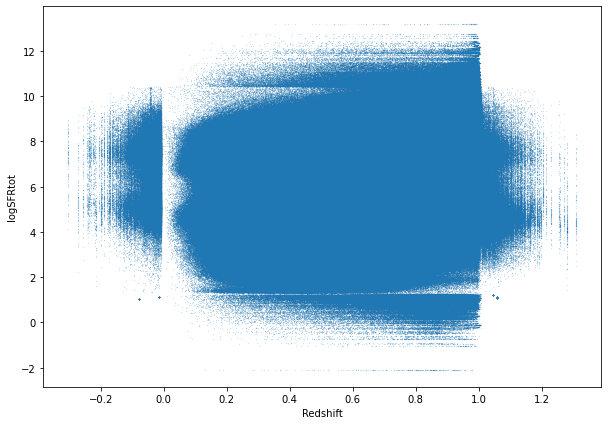

In [16]:
plt.figure(figsize=(10,7))
plt.plot(samples['redshift'], samples['logSFRtot'], 'o', ms=0.08)
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_pzFlowOnly.png",dpi=300, bbox_inches='tight')

In [17]:
samples_small = samples[(samples['Mag_true_r_sdss_z0'] < -2.) & (samples['Mag_true_r_sdss_z0'] > -3.)]
data_full_small = data[(data['Mag_true_r_sdss_z0'] < -2.) & (data['Mag_true_r_sdss_z0'] > -3.)]

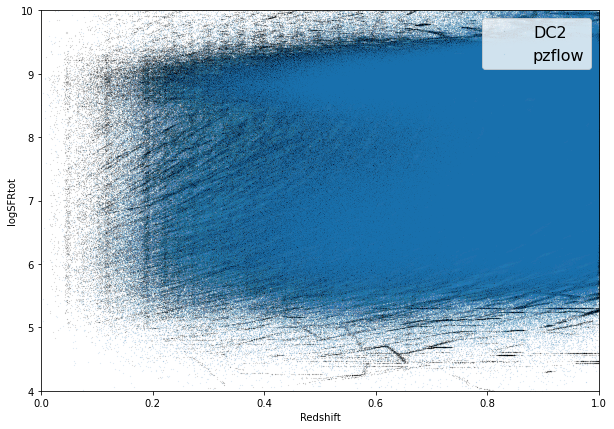

In [18]:
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
plt.legend(fontsize=16, loc='upper right')
#plt.savefig("SFR_vs_Redshift_pzFlow.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

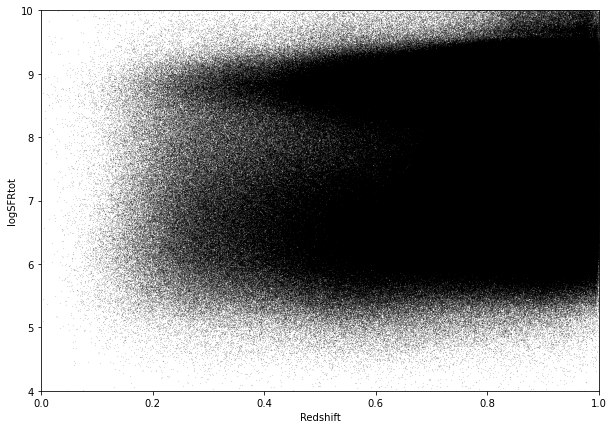

In [19]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(samples_small['redshift'], samples_small['logSFRtot'], 'o', ms=0.05, c='k', label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justPZFlow.png",dpi=300, bbox_inches='tight')

Text(0, 0.5, 'logSFRtot')

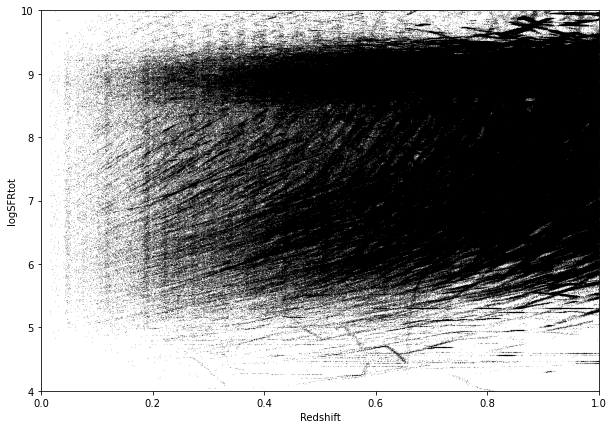

In [20]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(data_full_small['redshift'], data_full_small['logSFRtot'], 'o', ms=0.05, label='DC2', c='k')
plt.xlim((0, 1.0))
plt.ylim((4, 10.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_justDC2.png",dpi=300, bbox_inches='tight')

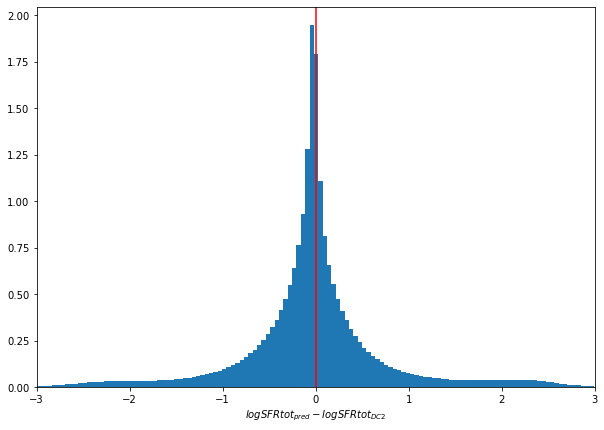

In [21]:
plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values - data['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
plt.axvline(x=0, c='r')
plt.xlim((-3, 3))
plt.xlabel(r"$logSFRtot_{pred} - logSFRtot_{DC2}$");
#plt.savefig("SFRtotPred_vs_SFRtotDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

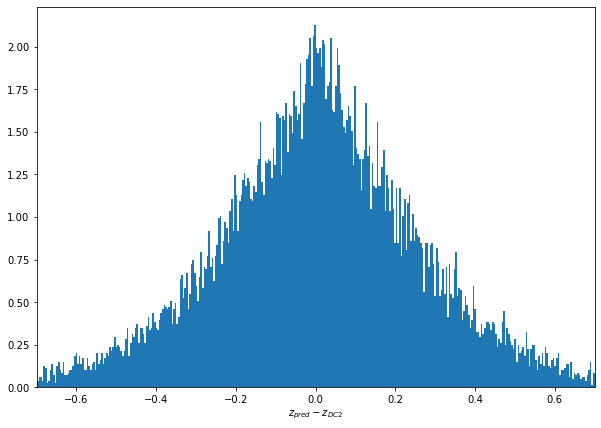

In [22]:
plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].sample(n=20000).values - data['redshift'].sample(n=20000).values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred} - z_{DC2}$");
#plt.savefig("zPred_vs_zDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')